In [4]:
# Step 1 - Load preprocessing outputs and set up environment
# Put this at the top of 03_KNN.ipynb


%run ./02_preprocessing.ipynb
# this line runs the complete preprocessing notebook itself

# 2) Imports we'll use in this notebook
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import joblib

# 3) Quick sanity prints so you know everything is loaded
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test  distribution:\n", y_test.value_counts(normalize=True))
print("\nPreprocessor type:", type(preprocessor))


Before cleaning:
Shape: (15200, 17)
Duplicate rows: 198

After removing duplicates and dropping faculty_id:
Shape: (15002, 16)
Duplicate rows (now): 0


,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution
0,Full Professor,Tenure-Track,8,83717.243906,5,23973.839447,Community College,Large,8,8.188558,2.827861,5.735050,7.0,3.429113,5.155787,0
1,Assistant Professor,Non-Tenure,3,45611.604269,9,21929.218175,Liberal Arts College,Small,3,2.369343,5.986704,5.598330,3.0,3.743535,1.000000,0
2,Associate Professor,Tenured,0,69397.334987,8,10317.051887,Technical Institute,Large,7,5.731299,2.289629,2.026023,4.0,4.849195,4.904489,0
3,Assistant Professor,Tenure-Track,7,57011.909828,5,50863.124935,Research University,Large,6,6.769015,9.967248,6.179585,3.0,4.328435,3.509004,1
4,Assistant Professor,Tenure-Track,15,57859.462561,7,47180.376820,Technical Institute,Medium,9,2.324824,6.939790,7.469714,4.0,4.031883,5.387402,1


Missing counts BEFORE:


research_funding             1200
base_salary                   450
work_life_balance             300
student_evaluation_avg        150
publications_last_3_years      75
dtype: int64


Created missing indicator flags for: ['research_funding', 'base_salary', 'work_life_balance', 'student_evaluation_avg', 'publications_last_3_years']

Numeric columns detected: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
Categorical columns detected: ['academic_rank', 'tenure_status', 'institution_type', 'department_size']

Missing counts AFTER imputation (features only):


Series([], dtype: int64)

Numeric columns to process: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives'] 

Initial numeric summary (first 8 cols):


,count,mean,std,min,25%,50%
years_at_institution,15002.0,10.424810,7.292135,0.000000,5.000000,10.000000
base_salary,15002.0,61031.994343,15484.561439,37273.531332,51415.427707,57344.793838
teaching_load,15002.0,6.074390,2.045789,1.000000,5.000000,6.000000
research_funding,15002.0,32845.619862,24361.853906,16.095170,20563.447288,31013.062378
admin_support,15002.0,5.993401,1.976132,1.000000,5.000000,6.000000
work_life_balance,15002.0,5.506365,1.926064,1.000000,4.179213,5.505122
department_collaboration,15002.0,5.981169,1.947210,1.000000,4.655716,5.990321
promotion_opportunities,15002.0,5.003399,1.949363,1.000000,3.640900,4.982620
publications_last_3_years,15002.0,3.622050,2.109037,0.000000,2.000000,3.000000
student_evaluation_avg,15002.0,3.988674,0.487100,1.952134,3.663822,3.991181


Outlier counts (IQR rule) per numeric column:
  teaching_load: 389
  research_funding: 251
  base_salary: 242
  admin_support: 173
  publications_last_3_years: 126
  years_at_institution: 82
  student_evaluation_avg: 51
  work_life_balance: 0
  department_collaboration: 0
  promotion_opportunities: 0
  job_market_alternatives: 0

Created outlier flag columns for: ['years_at_institution_outlier_flag', 'base_salary_outlier_flag', 'teaching_load_outlier_flag', 'research_funding_outlier_flag', 'admin_support_outlier_flag', 'publications_last_3_years_outlier_flag', 'student_evaluation_avg_outlier_flag']

Applied clipping at 1st and 99th percentiles for numeric columns.

Numeric summary after clipping + Robust scaling (first 8 cols):


,count,mean,std,min,25%,50%
years_at_institution,15002.0,0.039935,0.721822,-1.000000,-0.500000,0.000000e+00
base_salary,15002.0,0.203374,0.748109,-0.890086,-0.358007,0.000000e+00
teaching_load,15002.0,0.035029,1.017130,-2.500000,-0.500000,0.000000e+00
research_funding,15002.0,0.059123,0.791514,-1.331606,-0.461413,0.000000e+00
admin_support,15002.0,-0.003300,0.988066,-2.500000,-0.500000,0.000000e+00
work_life_balance,15002.0,0.000471,0.729885,-1.707224,-0.502455,0.000000e+00
department_collaboration,15002.0,-0.002411,0.726493,-1.741900,-0.499651,0.000000e+00
promotion_opportunities,15002.0,0.006497,0.718347,-1.473568,-0.496436,-1.643108e-16
publications_last_3_years,15002.0,0.202862,0.689129,-1.000000,-0.333333,0.000000e+00
student_evaluation_avg,15002.0,-0.001418,0.729213,-1.732407,-0.494331,0.000000e+00



Sample rows where outlier flags are 1 (first 10):


,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,department_collaboration,promotion_opportunities,publications_last_3_years,student_evaluation_avg,job_market_alternatives,left_institution,research_funding_missing_flag,base_salary_missing_flag,work_life_balance_missing_flag,student_evaluation_avg_missing_flag,publications_last_3_years_missing_flag,years_at_institution_outlier_flag,base_salary_outlier_flag,teaching_load_outlier_flag,research_funding_outlier_flag,admin_support_outlier_flag,publications_last_3_years_outlier_flag,student_evaluation_avg_outlier_flag
11,Full Professor,Tenured,1.9,2.051111,0.0,1.127421,Research University,Large,-1.0,0.737494,0.701510,0.727369,1.333333,-0.349340,1.168426,0,0,0,0,0,0,1,0,0,0,0,0,0
13,Assistant Professor,Non-Tenure,0.2,-0.403341,-0.5,2.049259,Research University,Medium,1.0,-0.804410,-0.365341,0.439138,-0.333333,-0.911319,-0.574307,1,0,0,0,0,0,0,0,0,1,0,0,0
18,Assistant Professor,Tenure-Track,-1.0,-0.472880,-1.5,-0.249774,Technical Institute,Medium,-2.5,0.020718,0.962496,0.214052,0.666667,1.185929,0.598105,1,0,0,0,0,0,0,0,0,0,1,0,0
25,Full Professor,Tenure-Track,-0.1,2.263782,0.5,1.393813,Research University,Medium,-0.5,-0.575267,-0.236408,-0.869257,0.666667,-0.379819,-0.298363,0,0,0,0,0,0,0,1,0,0,0,0,0
55,Full Professor,Non-Tenure,0.1,2.298579,0.0,0.165014,Liberal Arts College,Large,1.0,-0.226799,-0.041802,-1.206420,1.000000,-0.009958,0.301893,0,0,0,0,0,0,0,1,0,0,0,0,0
65,Full Professor,Tenure-Track,0.9,1.888247,-1.5,0.000000,Liberal Arts College,Medium,0.0,1.119363,0.332313,0.849212,2.000000,0.588038,-1.198746,0,1,0,0,0,0,0,0,0,0,0,1,0
80,Full Professor,Tenured,1.9,2.298579,-1.0,-0.675510,Liberal Arts College,Small,0.5,-0.647025,-0.269778,1.365244,1.333333,-0.385476,-0.881096,0,0,0,0,0,0,0,1,0,0,0,0,0
86,Assistant Professor,Tenured,1.9,0.501479,-1.0,-0.185808,Research University,Large,-1.0,0.000000,-0.544444,0.755210,-0.333333,0.383756,-0.476619,0,0,0,1,0,0,1,0,0,0,0,0,0
87,Full Professor,Tenured,0.3,1.231396,-1.0,2.271486,Research University,Large,0.5,-0.725624,0.490516,0.242155,0.333333,0.301360,-0.846159,1,0,0,0,0,0,0,0,0,1,0,0,0
91,Assistant Professor,Tenure-Track,1.9,-0.044098,2.0,0.524606,Technical Institute,Small,1.0,-0.783338,-0.090173,-0.318066,1.333333,-0.000181,-0.382627,0,0,0,0,0,0,1,0,0,0,0,0,0



Saved lists for pipeline:
  numeric_features: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'admin_support', 'work_life_balance', 'department_collaboration', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg', 'job_market_alternatives']
  outlier_flag_columns: ['years_at_institution_outlier_flag', 'base_salary_outlier_flag', 'teaching_load_outlier_flag', 'research_funding_outlier_flag', 'admin_support_outlier_flag', 'publications_last_3_years_outlier_flag', 'student_evaluation_avg_outlier_flag']
Categorical columns detected:
['academic_rank', 'tenure_status', 'institution_type', 'department_size'] 

Column: academic_rank
 Unique values: ['Full Professor' 'Assistant Professor' 'Associate Professor' 'Lecturer']
--------------------------------------------------
Column: tenure_status
 Unique values: ['Tenure-Track' 'Non-Tenure' 'Tenured']
--------------------------------------------------
Column: institution_type
 Unique values

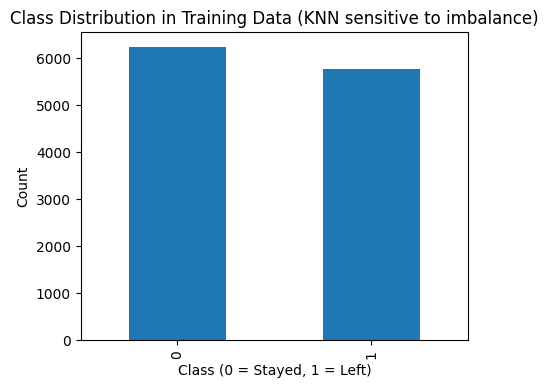

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution in Training Data (KNN sensitive to imbalance)")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


In [4]:
num_cols = X_train.select_dtypes(include=['number']).columns
print("Number of numeric features:", len(num_cols))
print(num_cols)


Number of numeric features: 23
Index(['years_at_institution', 'base_salary', 'teaching_load',
       'research_funding', 'admin_support', 'work_life_balance',
       'department_collaboration', 'promotion_opportunities',
       'publications_last_3_years', 'student_evaluation_avg',
       'job_market_alternatives', 'research_funding_missing_flag',
       'base_salary_missing_flag', 'work_life_balance_missing_flag',
       'student_evaluation_avg_missing_flag',
       'publications_last_3_years_missing_flag',
       'years_at_institution_outlier_flag', 'base_salary_outlier_flag',
       'teaching_load_outlier_flag', 'research_funding_outlier_flag',
       'admin_support_outlier_flag', 'publications_last_3_years_outlier_flag',
       'student_evaluation_avg_outlier_flag'],
      dtype='object')



Numeric sample selected: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding']


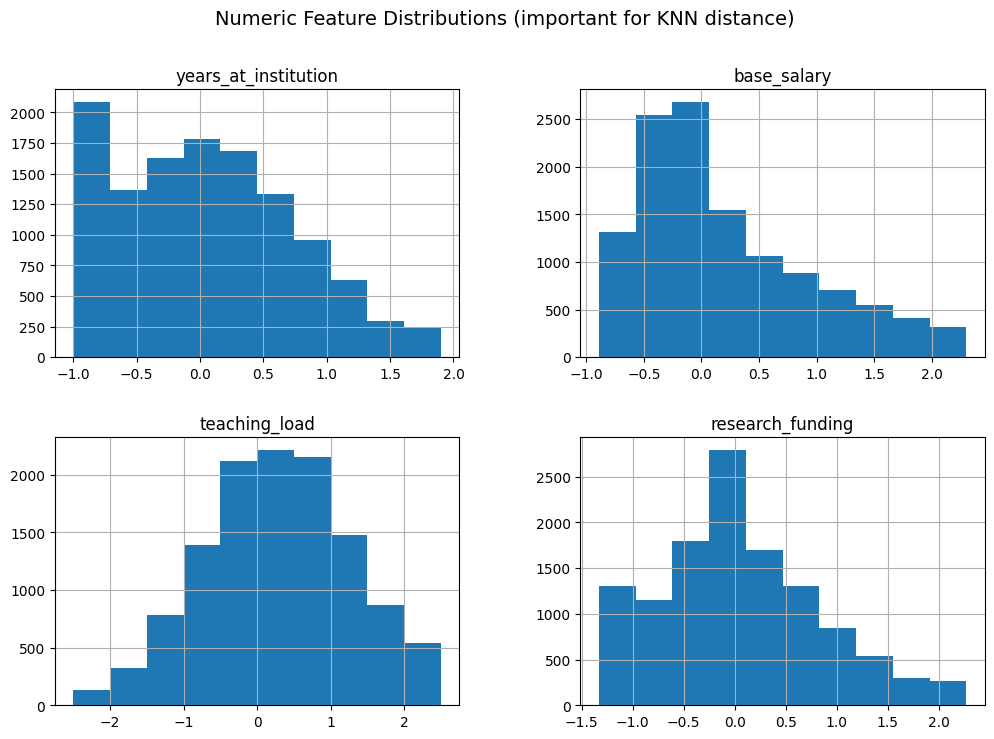

In [3]:
numeric_continuous = [col for col in numeric_cols if "_flag" not in col]

# Take first 4 for visualization
numeric_sample = numeric_continuous[:4]
print("\nNumeric sample selected:", numeric_sample)

df_train_numeric = X_train[numeric_sample]

df_train_numeric.hist(figsize=(12,8))
plt.suptitle("Numeric Feature Distributions (important for KNN distance)", fontsize=14)
plt.show()


Running PCA for 2D visualization...


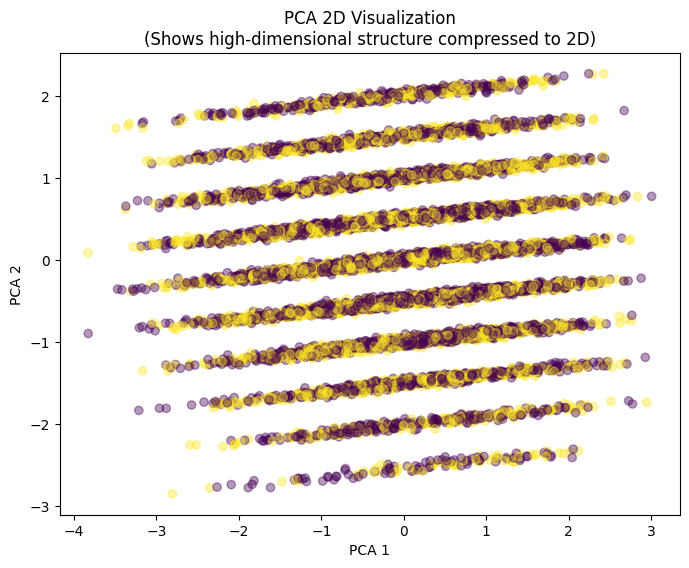

In [5]:
# ============================
# PART 2.3 — PCA Visualization
# ============================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Running PCA for 2D visualization...")

# ---------------------------------------------------------
# STEP 1 — Transform training data using the preprocessor
# ---------------------------------------------------------
# Preprocessor applies:
# • Scaling
# • OneHotEncoding
# • Missing/outlier flags
# • All your preprocessing pipeline steps
X_train_processed = preprocessor.transform(X_train)

# ---------------------------------------------------------
# STEP 2 — Convert sparse → dense (if needed)
# ---------------------------------------------------------
# OneHotEncoder often outputs sparse matrices.
# PCA may not accept sparse format.
if hasattr(X_train_processed, "toarray"):
    X_train_dense = X_train_processed.toarray()
else:
    X_train_dense = X_train_processed

# ---------------------------------------------------------
# STEP 3 — Apply PCA (reduce ~40D → 2D)
# ---------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_dense)

# ---------------------------------------------------------
# STEP 4 — Plot PCA scatter
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],         # PCA 1 on x-axis
    X_pca[:, 1],         # PCA 2 on y-axis
    c=y_train,           # Color by class (0 or 1)
    alpha=0.4
)

plt.title("PCA 2D Visualization\n(Shows high-dimensional structure compressed to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()




Running KNN for different K values...
K = 1 → Accuracy = 0.5348
K = 3 → Accuracy = 0.5408
K = 5 → Accuracy = 0.5408
K = 7 → Accuracy = 0.5448
K = 9 → Accuracy = 0.5418
K = 11 → Accuracy = 0.5348
K = 13 → Accuracy = 0.5432
K = 15 → Accuracy = 0.5478
K = 17 → Accuracy = 0.5442
K = 19 → Accuracy = 0.5455
K = 21 → Accuracy = 0.5508
K = 23 → Accuracy = 0.5555
K = 25 → Accuracy = 0.5571
K = 27 → Accuracy = 0.5535
K = 29 → Accuracy = 0.5615
K = 31 → Accuracy = 0.5561
K = 33 → Accuracy = 0.5521
K = 35 → Accuracy = 0.5545
K = 37 → Accuracy = 0.5591
K = 39 → Accuracy = 0.5555


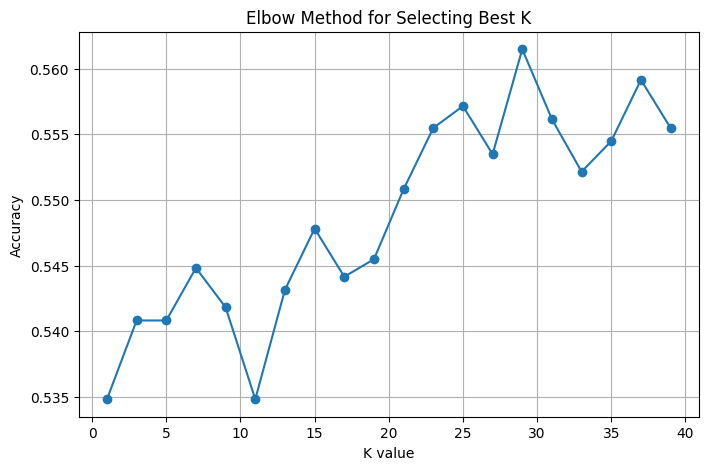


Best K based on highest accuracy: 29


In [6]:
# ============================================
# KNN — Elbow Method to Choose Best K
# ============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = list(range(1, 41, 2))  # odd K values from 1 to 29
accuracies = []

print("Running KNN for different K values...")

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Create full pipeline: preprocessing + model
    model = Pipeline([
        ("preprocess", preprocessor),
        ("knn", knn)
    ])
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict on test
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"K = {k} → Accuracy = {acc:.4f}")

# Plot K vs Accuracy
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow Method for Selecting Best K")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# Best K
best_k = k_values[accuracies.index(max(accuracies))]
print(f"\nBest K based on highest accuracy: {best_k}")


Training Final KNN Model with K = 29...

Final KNN Accuracy (K=29): 0.5615


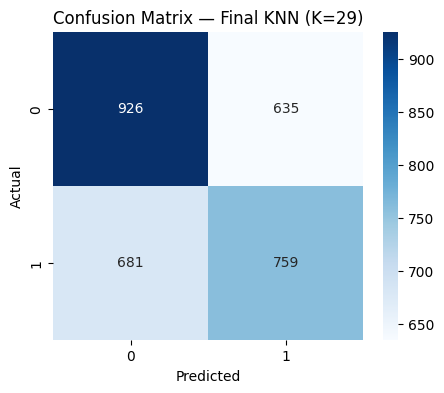


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1561
           1       0.54      0.53      0.54      1440

    accuracy                           0.56      3001
   macro avg       0.56      0.56      0.56      3001
weighted avg       0.56      0.56      0.56      3001



In [7]:
# ============================================
# FINAL KNN MODEL (with best K = 29)
# ============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Training Final KNN Model with K = 29...")

# Step 1 — Build final model pipeline
knn_final = Pipeline([
    ("preprocess", preprocessor),         # scaling + OHE + flags
    ("knn", KNeighborsClassifier(n_neighbors=29))
])

# Step 2 — Fit the model
knn_final.fit(X_train, y_train)

# Step 3 — Predict on test set
y_pred = knn_final.predict(X_test)

# Step 4 — Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal KNN Accuracy (K=29): {accuracy:.4f}")

# Step 5 — Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final KNN (K=29)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 6 — Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Generating ROC Curve and AUC Score for KNN (K = 29)...
AUC Score (KNN K=29): 0.5803


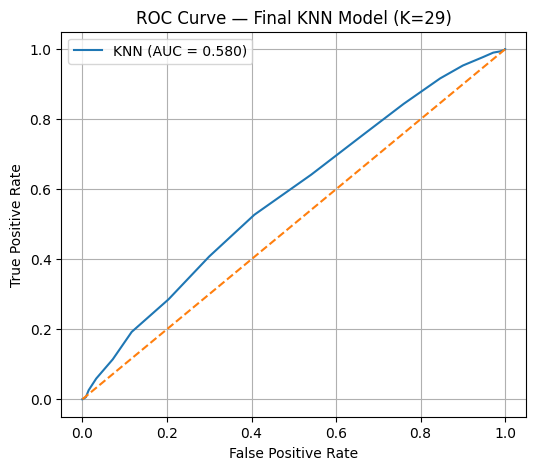

In [8]:
# ============================================
# ROC Curve + AUC Score for Final KNN (K = 29)
# ============================================

from sklearn.metrics import roc_curve, roc_auc_score

print("\nGenerating ROC Curve and AUC Score for KNN (K = 29)...")

# Step 1 — Get probability predictions (needed for ROC)
# KNN gives probabilities via predict_proba()
y_prob = knn_final.predict_proba(X_test)[:, 1]   # probability of class '1' (left)

# Step 2 — Calculate FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 3 — Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC Score (KNN K=29): {auc_score:.4f}")

# Step 4 — Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.3f})')
plt.plot([0,1], [0,1], linestyle='--')  # diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Final KNN Model (K=29)")
plt.legend()
plt.grid(True)
plt.show()
